# ArviZ Quickstart

In [1]:
%matplotlib inline
import arviz as az
import numpy as np

In [2]:
# ArviZ ships with style sheets!
az.style.use('arviz-darkgrid')  

## Get started with plotting

ArviZ is designed to be used with libraries like [PyStan](https://pystan.readthedocs.io) and [PyMC3](https://docs.pymc.io), but works fine with raw numpy arrays.

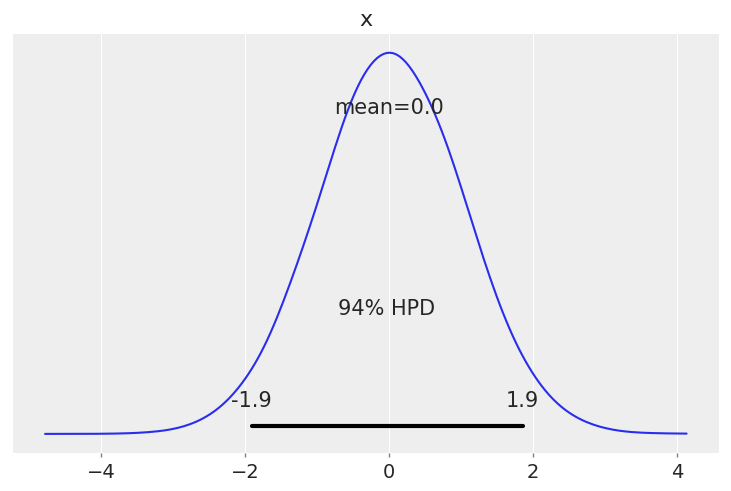

In [3]:
az.plot_posterior(np.random.randn(100_000));

Plotting a dictionary of arrays, ArviZ will interpret each key as the name of a different random variable. Each row of an array is treated as an independent series of draws from the variable, called a _chain_. Below, we have 10 chains of 50 draws each for four different distributions.

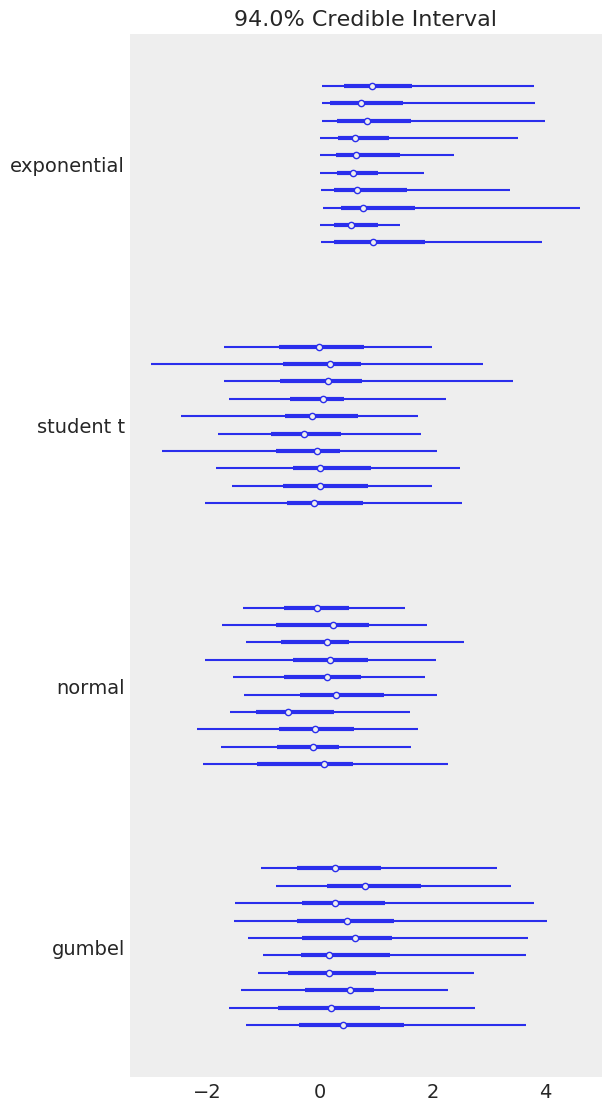

In [4]:
size = (10, 50)
az.plot_forest({
    'normal': np.random.randn(*size),
    'gumbel': np.random.gumbel(size=size),
    'student t': np.random.standard_t(df=6, size=size),
    'exponential': np.random.exponential(size=size)
});

## Plotting with PyMC3 objects

ArviZ is designed to work well with high dimensional, labelled data. Consider the [eight schools model](http://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/), which roughly tries to measure the effectiveness of SAT classes at eight different schools. To show off ArviZ's labelling, I give the schools the names of [a different eight schools](https://en.wikipedia.org/wiki/Eight_Schools_Association).

This model is small enough to write down, is hierarchical, uses labelling, and a centered parameterization causes [divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) (which are interesting for illustration):

In [5]:
import pymc3 as pm

J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter', 
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])


with pm.Model() as centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)
    
    # This pattern is useful in PyMC3
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 683.44draws/s]
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45072586574503554, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9144893861572339, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 3579.53it/s]


Most ArviZ functions work fine with `trace` objects from PyMC3:

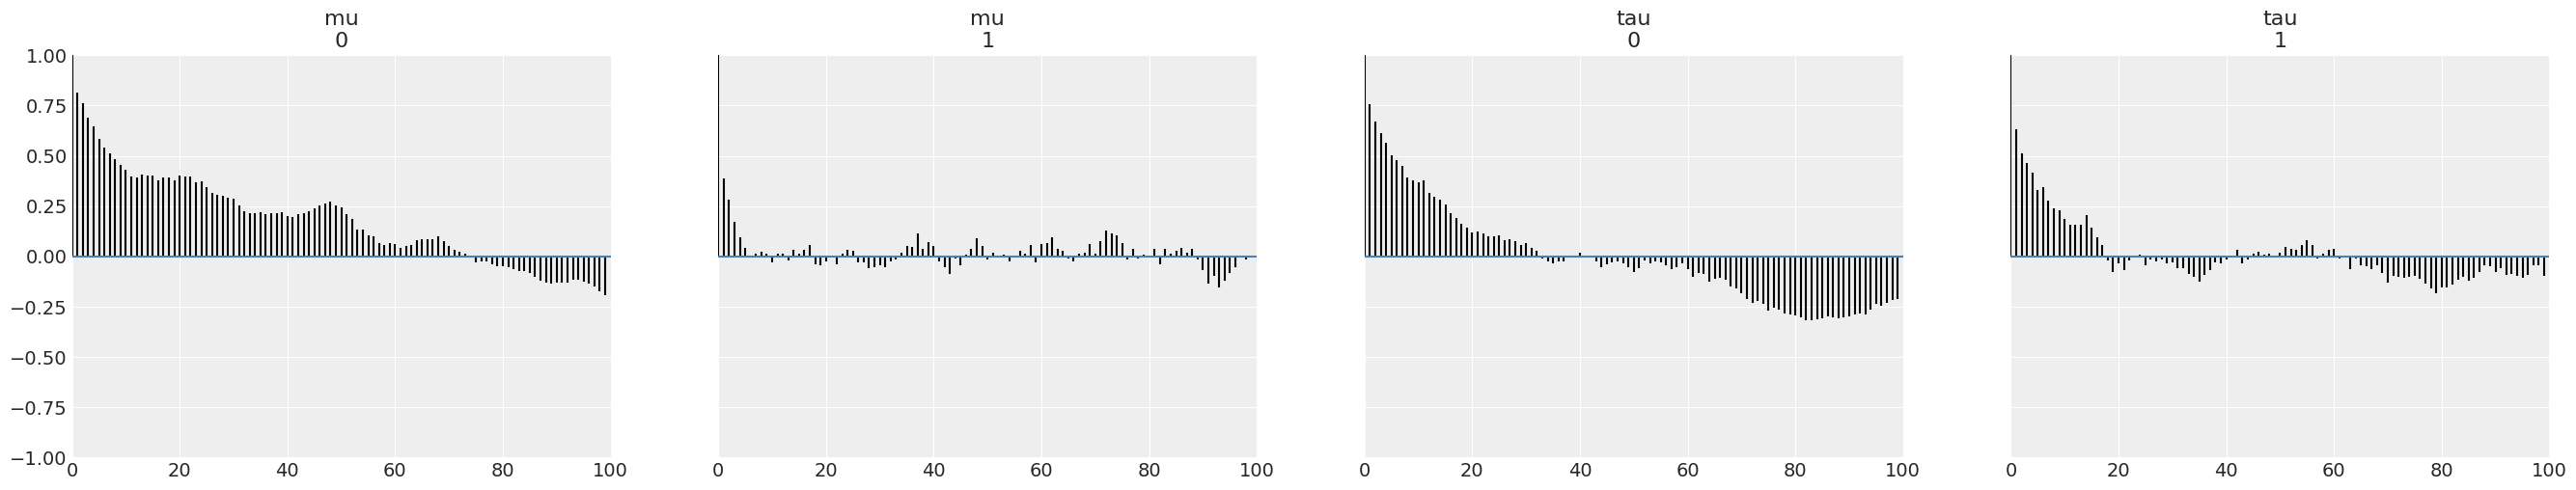

In [6]:
az.plot_autocorr(centered_eight_trace, var_names=['mu', 'tau']);

### Convert to InferenceData

For much more powerful querying, analysis and plotting, we can use built-in ArviZ utilities to convert PyMC3 objects to xarray datasets. Note we are also giving some information about labelling.

ArviZ is built to work with `InferenceData`, and the more *groups* it has access to, the more powerful analyses it can perform. Here is a plot of the trace, which is common in PyMC3 workflows. Note the intelligent labels.

In [7]:
data = az.from_pymc3(trace=centered_eight_trace, 
                     prior=prior, 
                     posterior_predictive=posterior_predictive,
                     coords={'school': schools},
                     dims={'theta': ['school'], 'obs': ['school']})
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

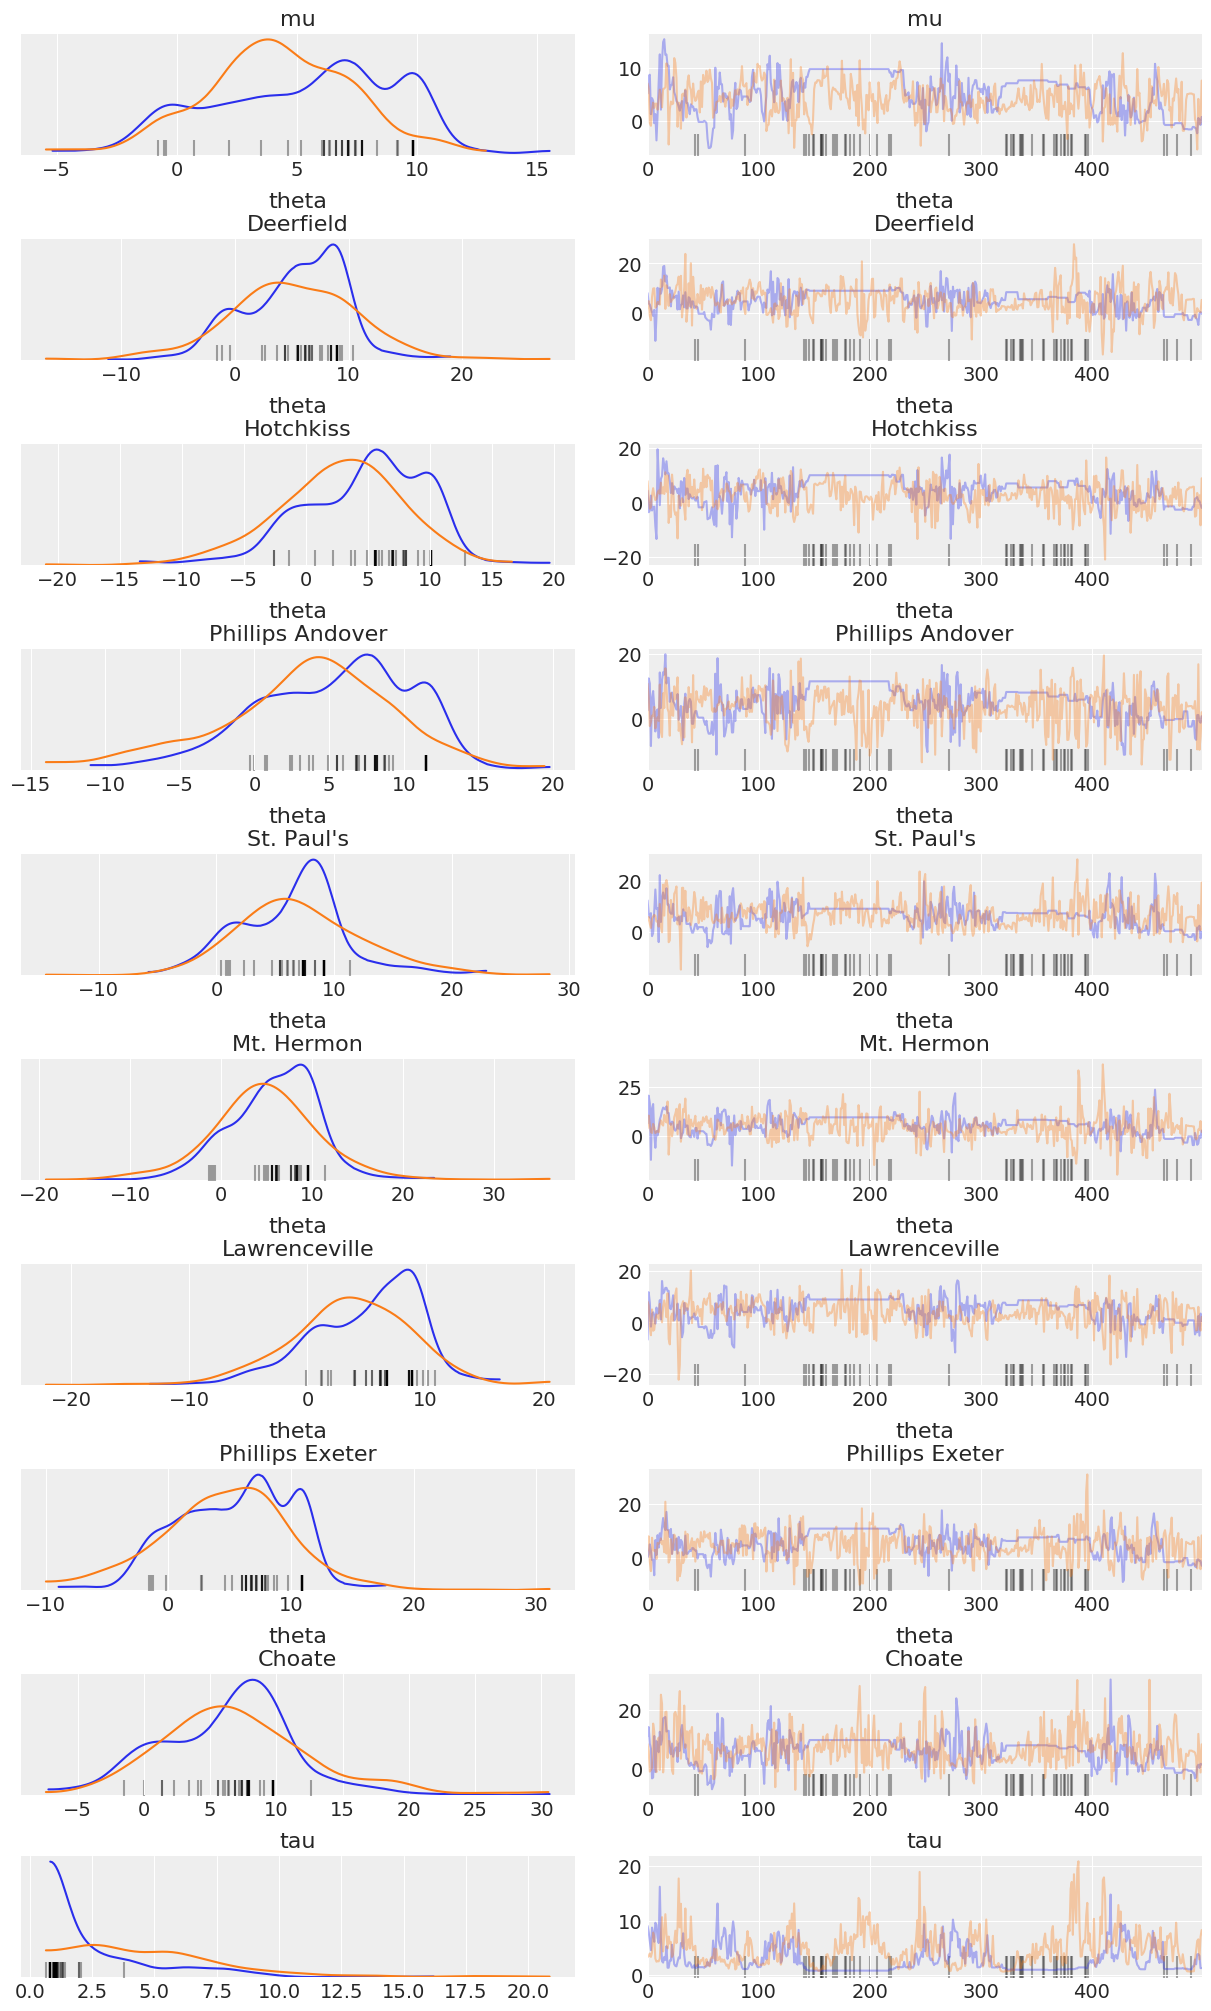

In [8]:
az.plot_trace(data);

## Plotting with PyStan objects

ArviZ is built with first class support for PyStan objects, and can plot raw `fit` objects in a reasonable manner. Here is the same centered eight schools model:

In [9]:
import pystan


schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code, verbose=False)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0eada194ad938e30ed47926216f98ca NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816,
                 from /home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpfet4cacy/stanfit4anon_model_b0eada194ad938e30ed47926216f98ca_2487659712711866596.cpp:642:
/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^~~~~~~
In file included from /home/osvaldo/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.66.0/boost/mpl/au

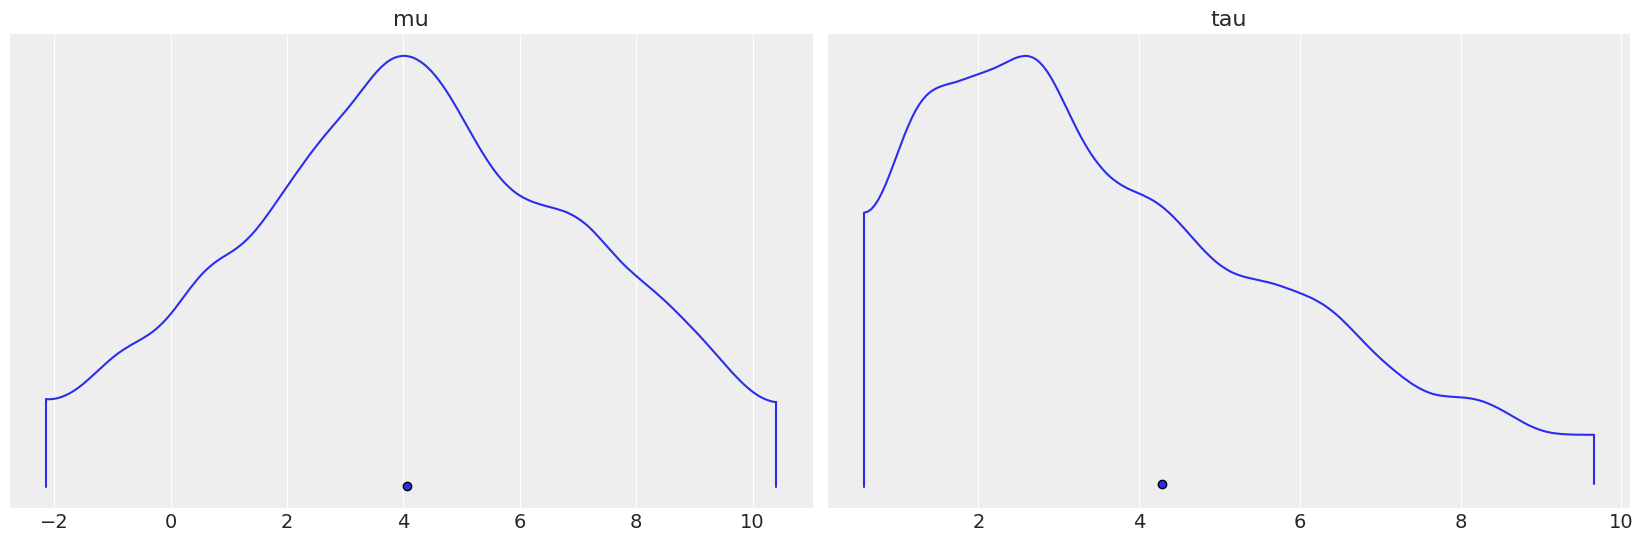

In [10]:
az.plot_density(fit, var_names=['mu', 'tau']);

Again, converting to `InferenceData` (a netcdf datastore that loads data into `xarray` datasets), we can get much richer labelling and mixing of data. Here is a plot showing where the Hamiltonian sampler had divergences

In [11]:
data = az.from_pystan(posterior=fit,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'school': schools},
                      dims={'theta': ['school'], 'y': ['school'], 'log_lik': ['school'], 'y_hat': ['school'], 'theta_tilde': ['school']})
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

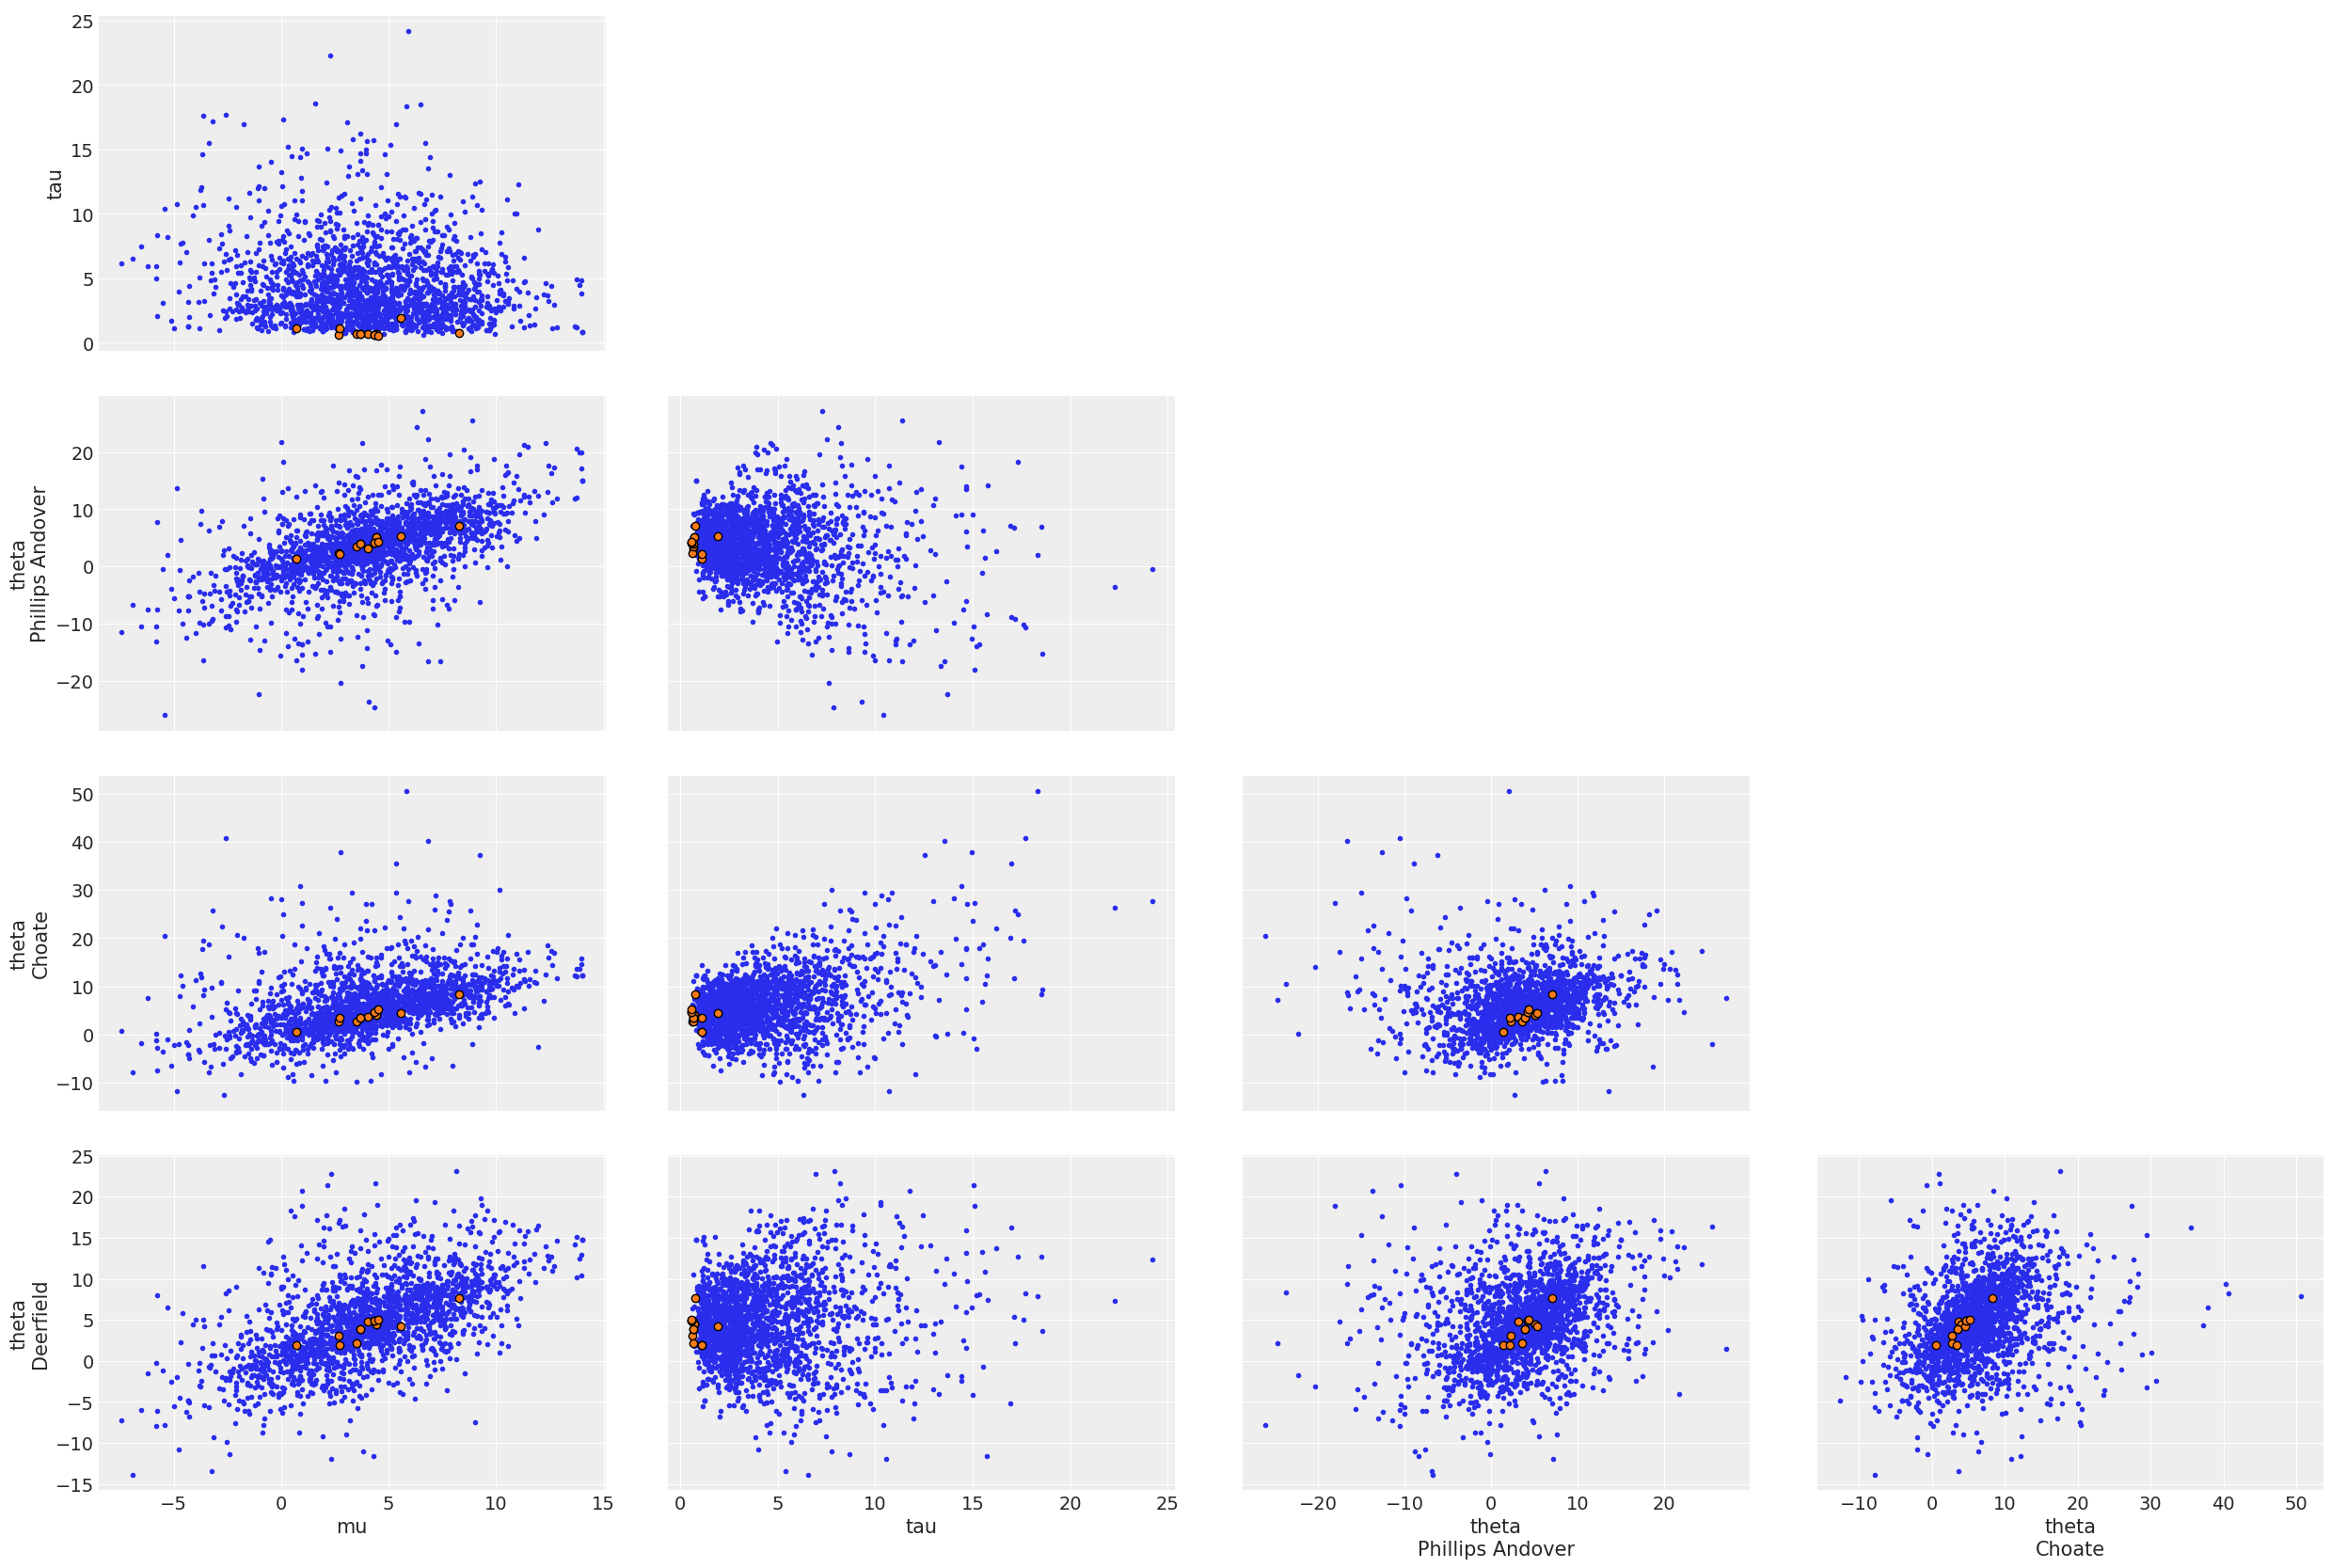

In [12]:
az.plot_pair(data, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);